## <center>Probabilistic Programming Workflow</center>

### <center>Open Source Tools for Rapid Reproducible Bayesian Model Development</center>

<a id='TOP'></a>
### Notebook Content:
1. [Overview](#Overview)
    1. [Ensuring Reproducibility](#Reprod)
    2. [PP as modeling framework](#PPOverview)
2. [Loading Field Data](#DataLoad)
3. [Pre-Processing](#DataPrep)
   1. [Data Cleaning](#cleaning)
   2. [Exogenous Feature Extraction](#exo)
       1. [Dealing with time data](#datetime)
       2. [Consolidating fluo/hplc chl](#fluo/hplc)
       2. [Log-transform](#log)
       3. [Green-to-max(Blue) ratio](#green2blue)
       4. [Sub-grouping](#sub)
   4. [Data Splitting into Train/Test Sets](#split)
   5. [Endogenous Data Transformation](#endo)
       1. [Scaling Data](#scale)
   6. [Preserving the preprocessing pipeline](#picklepreprocess)
4. [Bayesian Modelling](#PyMC3)
   1. [Model coding](#writemodel)
   2. [Prior evaluation & Model modification](#priors)
   3. [Model fitting & diagnostics](#fit)
   4. [Model evaluation](#eval)
       1. [Deviance](#deviance)
       2. [Approximation by WAIC](#waic)
5. [Conclusion](Conclusion)

[Back to Contents](#TOP)

## 1. <u>Overview</u>
* Catching up with Probabilistic Programming
* Loading Data -- PanDaS
* Preparing Data -- PanDaS, Seaborn, Scikit-learn
* Rapid Model Development -- PyMC3
* Beyond the Basics

In [1]:
# STL
import os
import pickle
import sys

# numerical libraries
import numpy as np
import pandas as pd
import pymc3 as pm
from sklearn.decomposition import PCA
from sklearn.metrics import mean_absolute_error as mae_score
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn import __version__ as skver
from theano import shared


# graphic facilities
import matplotlib.pyplot as pl
from matplotlib import rcParams
from matplotlib import __version__ as mpver
import seaborn as sb

In [2]:
# NOTEBOOK-WIDE Graphical settings
rcParams['axes.formatter.limits'] = (-2, 3)
rcParams['axes.titlesize'] = 18
rcParams['axes.labelsize'] = 16
rcParams['font.size'] = 16
rcParams['ytick.labelsize'] = 16
rcParams['xtick.labelsize'] = 16
rcParams['legend.fontsize'] = 16
rcParams['xtick.minor.visible'] = True

In [3]:
print(f'Matplotlib version..: {mpver}')
print(f'Python version......: {sys.version.split("|")[0]}')
print(f'PanDaS version......: {pd.__version__}')
print(f'Scikit-Learn version: {skver}')
print(f'Seaborn version.....: {sb.__version__}')
print(f'PyMC3 version.......: {pm.__version__}')

Matplotlib version..: 3.0.2
Python version......: 3.6.8 
PanDaS version......: 0.24.1
Scikit-Learn version: 0.20.3
Seaborn version.....: 0.9.0
PyMC3 version.......: 3.6


In [5]:
%matplotlib inline

### Loading and preparing data -- PANDAS
* the nomad dataset
* reading in 
* get column names
* extract desired variables

### Data Exploration -- PANDAS, Seaborn and Scikit-Learn
* predictor isolated distributions
* plotting predictors/predicted w/ respect to each other
* predictor correlation, multicollinearity and pca

### Modeling -- Probabilistic Programming with PyMC3
* simple bayesian regression to predict chlorophyll from Rrs
* rapid but transparent model development
* evaluation of priors
* fitting and evaluation of posterior distribution
* model comparison/selection

[Back to Contents](#TOP)

<a id=DataLoad></a>
## 2. <u>Loading Field Data</u>
<br>
<span style="font-size:16pt">$\ \ \ \Rightarrow$ NOMAD SeaWiFS validation match-up distribution</span><br>
<center><img src='./resources/nomad_seabass_v1_seawifs_map.png?:2' width=900 title="NOMAD SeaWiFS validation match-up distribution"/></center>

<span style="font-size:16pt">$\Rightarrow$   <u>Predictors</u></span>
* sat_rrs  ~ satellite remote-sensing reflectance (sr-1)
* etopo2 ~ NGDC ETOPO2 water depth (meters)
* oisst    ~ optimal interpolation (OI) sea surface temperature (SST) (degrees C)
---
<span style="font-size:16pt">$\Rightarrow$   <u>Predicted</u></span>
* chl ~ fluorometric chlorophyll a

<u>Other</u>
* id ~ NOMAD record identifier (unitless)

<span style="font-size:16pt">$\Rightarrow$   <u>File content</u></span>
<br><br>
/fields=year,month,day,hour,minute,second,lat,lon,id,oisst,etopo2,chl,chl_a,kd405,kd411,kd443,kd<br>
...<br>
_rrs490,sat_rrs510,sat_rrs555,sat_rrs670,sat_file,tdiff,solz,senz,cv,valid<br>
/units=-999<br>
/end_header<br>
1997,10,07,09,41,00,42.51,39.52,4065,19.54,1982,0.401,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,...

In [4]:
with open('./nomad_seawifs_v1.3_2005262.txt') as f:
    for i, line in enumerate(f.readlines()):
        if 'fields' in line:
            # collect column labels
            col_names = line.strip('/fields=').strip().split(',') 
        if '/end_header' in line:
            # record rows to skip
            rowskips = i+1 # i is 0-indexed
            break

In [5]:
df = pd.read_csv('./nomad_seawifs_v1.3_2005262.txt', header=None,
                 names=col_names, skiprows=rowskips, na_values=-999)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 292 entries, 0 to 291
Columns: 169 entries, year to valid
dtypes: float64(157), int64(10), object(2)
memory usage: 385.6+ KB


In [7]:
df.head(2)

,year,month,day,hour,minute,second,lat,lon,id,oisst,...,sat_rrs490,sat_rrs510,sat_rrs555,sat_rrs670,sat_file,tdiff,solz,senz,cv,valid
0,1997,10,7,9,41,0,42.51,39.52,4065,19.54,...,0.00345,0.00297,0.00217,0.00026,S1997280094210.L1A_GAC,480,49.0,25.4,0.2098,0
1,1997,10,11,9,32,0,39.29,25.11,4069,19.57,...,0.00494,0.00348,0.00191,0.00018,S1997284110315.L1A_MLAC,5880,48.7,37.8,0.1043,1


[Back to Contents](#TOP)

<a id=DataPrep></a>
## 3. <u>Pre-Processing</u>

<a id=cleaning></a>
### A. Developing a Data Cleaning Plan

* Don't drop bad data
* Flag it (replace with NaN)
* Retain bad entry for possible later imputation

In [10]:
df.filter(regex=('(sat_rrs|chl)'), axis=1).describe()

,chl,chl_a,sat_rrs412,sat_rrs443,sat_rrs490,sat_rrs510,sat_rrs555,sat_rrs670
count,262.000000,33.000000,292.000000,292.000000,292.000000,292.000000,292.000000,292.000000
mean,1.527438,1.658129,0.005039,0.005038,0.005050,0.004010,0.003162,0.000501
std,3.600463,3.846960,0.003753,0.002865,0.002460,0.002301,0.002645,0.000706
min,0.030000,0.027000,-0.006620,-0.002560,-0.000680,0.000850,0.001090,-0.000790
25%,0.172525,0.060000,0.002107,0.002780,0.003395,0.002770,0.001708,0.000140
50%,0.381000,0.135000,0.004625,0.005265,0.005040,0.003405,0.002120,0.000230
75%,1.382400,1.761000,0.007120,0.006877,0.006262,0.004370,0.003555,0.000560
max,43.100000,20.602000,0.015460,0.012450,0.018730,0.019950,0.021740,0.005000


$\rightarrow$ consolidate date/time columns<br>
$\rightarrow$ consolidate fluo/hplc chlorophyll columns<br>
$\rightarrow$ deal with negative Rrs values

<a id=datetime></a>
#### a. Dealing with date/time data: 
$\ \ \ \Rightarrow$ Consolidation of multiple date/time columns into single column of datetime objects

In [13]:
date_time_columns = ['year', 'month', 'day', 'hour', 'minute', 'second']
df.insert(0, 'datetime', pd.to_datetime(df[date_time_columns],
                                        format='%Y-%m-%d %H:%M:%S'))
df.drop(date_time_columns, axis=1, inplace=True)

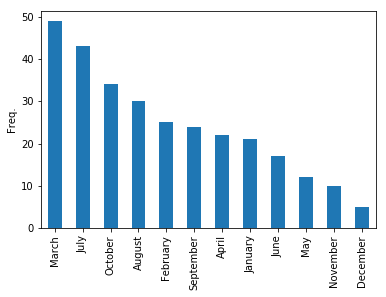

In [14]:
ax = df.datetime.dt.month_name().value_counts().plot(kind='bar')
ax.set_ylabel('Freq.');

<a id=hplcfluo></a>
#### b. Consolidating hplc/fluo chlorophyll data

In [15]:
# two types of chlorophyll a:
df.filter(regex='chl', axis=1).info()
# chl: obtained by fluorometry
# chl_a: obtained by hplc

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 292 entries, 0 to 291
Data columns (total 2 columns):
chl      262 non-null float64
chl_a    33 non-null float64
dtypes: float64(2)
memory usage: 4.6 KB


In [16]:
def fill_chl(row):
    return row['chl_a'] if np.isfinite(row['chl_a']) else row['chl']

In [17]:
# fill consolidated chlor_a column with chl_a (hplc) when possible, chl (fluo) otherwise
df['chlor_a'] = df.apply(fill_chl, axis=1)

In [18]:
# Flag chlor_a measurement type; hplc/fluo 
df['is_hplc'] = np.isfinite(df.chl_a)

In [19]:
df.filter(regex='chl', axis=1).info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 292 entries, 0 to 291
Data columns (total 3 columns):
chl        262 non-null float64
chl_a      33 non-null float64
chlor_a    292 non-null float64
dtypes: float64(3)
memory usage: 6.9 KB


[Back to Contents](#TOP)

#### c. Cleaning Rrs

In [11]:
# assign Nan to nonpositive sat. Rrs
sat_cols = df.filter(regex='sat_rrs', axis=1).columns

In [12]:
for col in sat_cols:
    df.loc[df[col]<=0, col] = np.NaN

[Back to Contents](#TOP)

<a id=exo></a>
### B. Exogenous Feature Transformation

$\ \ \ \Rightarrow$ Transformation is independent of dataset properties

[Back to Contents](#TOP)

<a id=log></a>
#### c. Training-independent scaling: log-transform

In [20]:
# Log-transform Rrs Data
for col in sat_cols:
    df[f'log_{col}'] = np.log10(df[col])

In [21]:
# Log-transform Chl Data
df['log_chlor_a'] = np.log10(df.chlor_a)

In [22]:
df.filter(regex='(rrs|chlor_a)', axis=1).head(2)

,sat_rrs412,sat_rrs443,sat_rrs490,sat_rrs510,sat_rrs555,sat_rrs670,chlor_a,log_sat_rrs412,log_sat_rrs443,log_sat_rrs490,log_sat_rrs510,log_sat_rrs555,log_sat_rrs670,log_chlor_a
0,0.00239,0.00288,0.00345,0.00297,0.00217,0.00026,0.401,-2.621602,-2.540608,-2.462181,-2.527244,-2.663540,-3.585027,-0.396856
1,0.00572,0.00592,0.00494,0.00348,0.00191,0.00018,0.091,-2.242604,-2.227678,-2.306273,-2.458421,-2.718967,-3.744727,-1.040959


#### d. Blue-green ratio

* similar to OC4 variable but inverse
* not polynomial
* takes into account dominant blue band
$$\large{X=log_{10}\left(\frac{Rrs_{555}}{max(Rrs_{443}, Rrs_{490}, Rrs_{510})}\right)}$$

In [332]:
blue_band_cols = ['log_sat_rrs412', 'log_sat_rrs443', 'log_sat_rrs490', 'log_sat_rrs510']
df['log_maxBlue'] = df[blue_band_cols].max(axis=1)
df['maxBlueID'] = df[blue_band_cols].idxmax(axis=1)
df['maxBlueID'] = df.maxBlueID.str.extract('(rrs[0-9]+)').iloc[:, 0].str.capitalize()

In [333]:
df[['log_maxBlue', 'maxBlueID'] + blue_band_cols].head()

,log_maxBlue,maxBlueID,log_sat_rrs412,log_sat_rrs443,log_sat_rrs490,log_sat_rrs510
0,-2.462181,Rrs490,-2.621602,-2.540608,-2.462181,-2.527244
1,-2.227678,Rrs443,-2.242604,-2.227678,-2.306273,-2.458421
2,-2.003051,Rrs412,-2.003051,-2.073143,-2.204120,-2.425969
3,-2.714443,Rrs510,-3.154902,-2.910095,-2.752027,-2.714443
4,-2.703335,Rrs510,-3.136677,-2.903090,-2.744727,-2.703335


In [334]:
df['green2MaxBlue'] = df.log_sat_rrs555 - df.log_maxBlue

In [335]:
df[blue_band_cols + ['log_maxBlue', 'maxBlueID', 'green2MaxBlue']].head()

,log_sat_rrs412,log_sat_rrs443,log_sat_rrs490,log_sat_rrs510,log_maxBlue,maxBlueID,green2MaxBlue
0,-2.621602,-2.540608,-2.462181,-2.527244,-2.462181,Rrs490,-0.201359
1,-2.242604,-2.227678,-2.306273,-2.458421,-2.227678,Rrs443,-0.491288
2,-2.003051,-2.073143,-2.204120,-2.425969,-2.003051,Rrs412,-0.771640
3,-3.154902,-2.910095,-2.752027,-2.714443,-2.714443,Rrs510,0.006699
4,-3.136677,-2.903090,-2.744727,-2.703335,-2.703335,Rrs510,0.002188


In [336]:
df.maxBlueID.value_counts()

Rrs412    119
Rrs490     87
Rrs510     72
Rrs443     14
Name: maxBlueID, dtype: int64

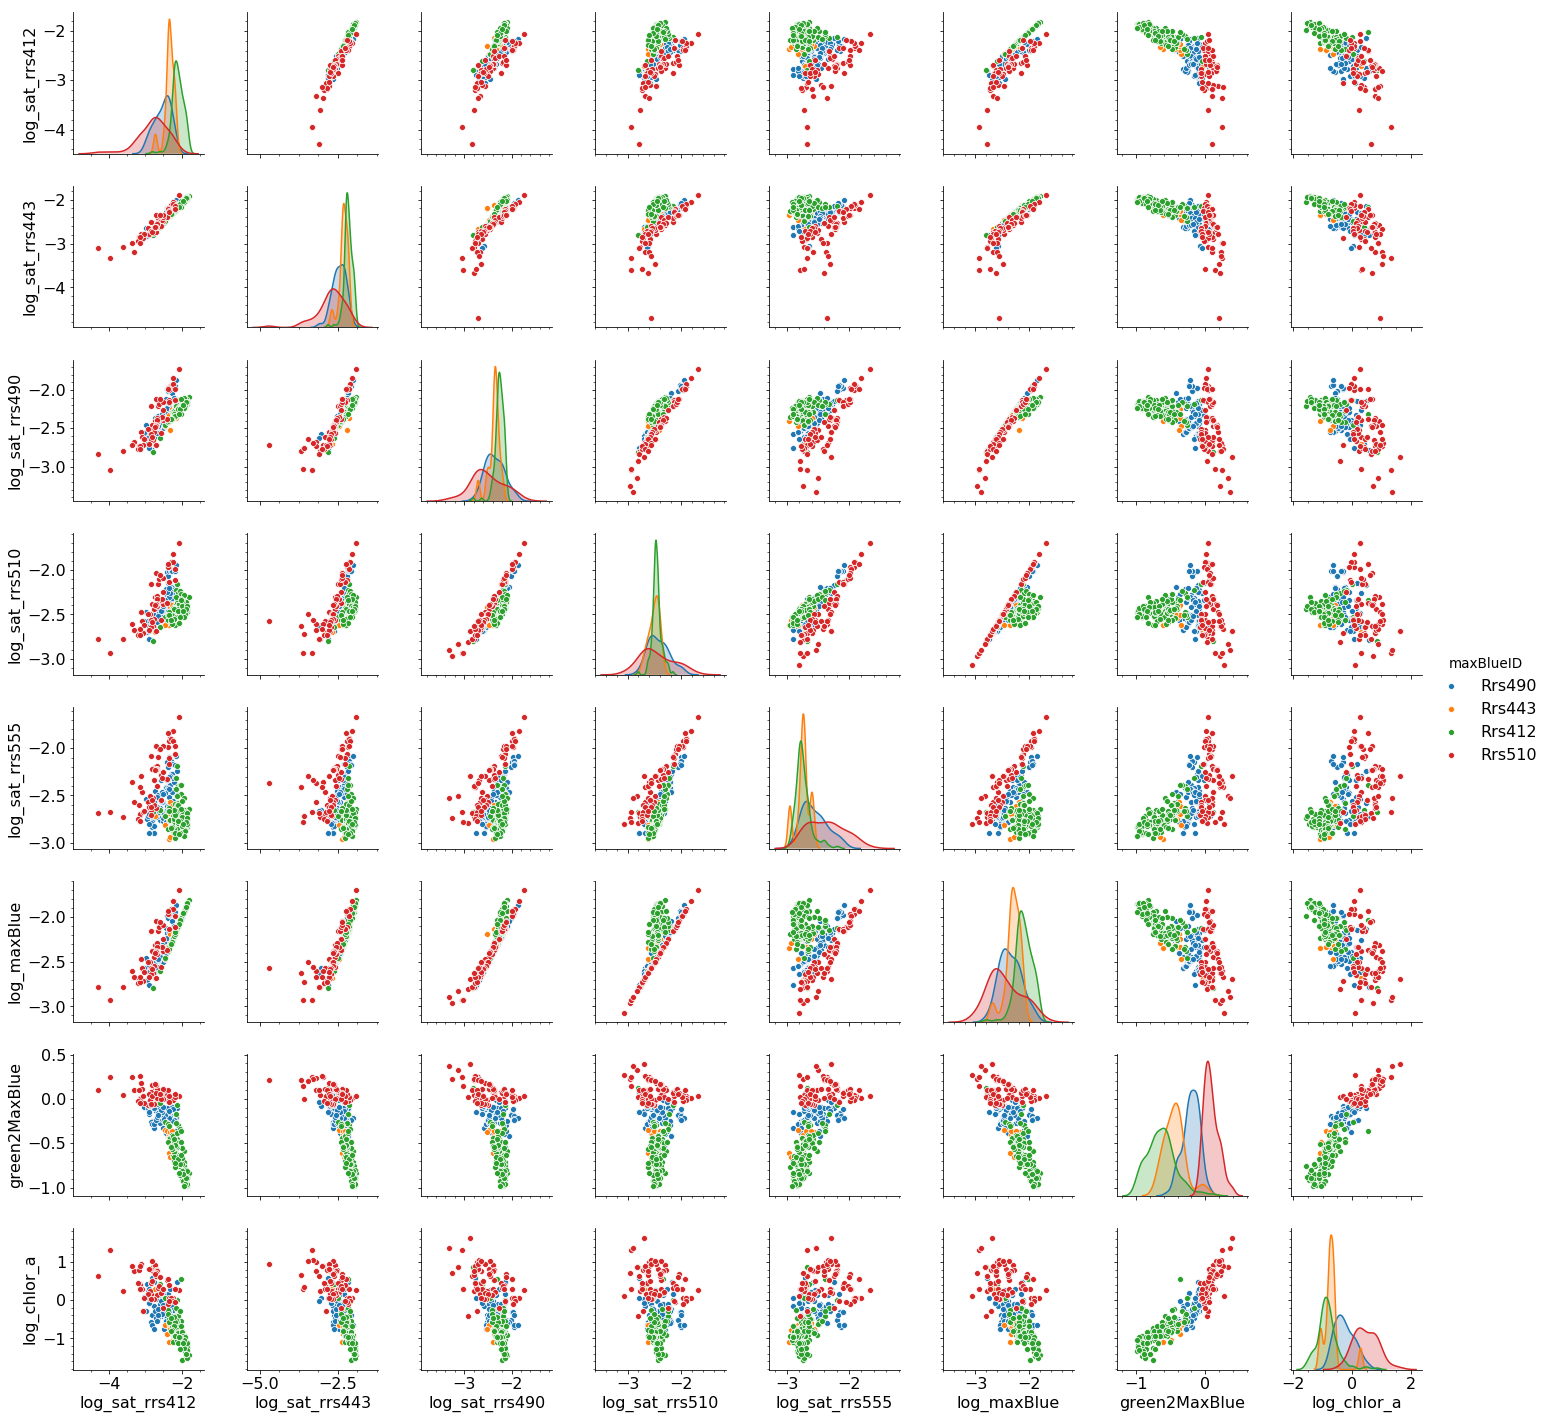

In [337]:
sb.pairplot(df[blue_band_cols + ['log_sat_rrs555'] +
               ['log_maxBlue', 'maxBlueID', 'green2MaxBlue', 'log_chlor_a']],
            hue='maxBlueID')

#### e. Sub-grouping

In [23]:
df['coastal'] = df.etopo2.apply(lambda x: x<=30)

In [24]:
df['coastal_idx'] = df.coastal.astype('category').cat.codes.astype('int')

In [28]:
df.filter(regex='coastal', axis=1).head()

,coastal,coastal_idx
0,False,0
1,False,0
2,False,0
3,False,0
4,False,0


[Back to Contents](#TOP)

<a id=split></a>
### C. Splitting Data into Train/Test Sets

#### a. Extract relevant subset

In [29]:
data_extr = [f'log_{col}' for col in sat_cols] + ['oisst', 'coastal', 'coastal_idx', 'log_chlor_a'] 

In [30]:
df_extr = df.loc[:, data_extr]
df_extr.head()

,log_sat_rrs412,log_sat_rrs443,log_sat_rrs490,log_sat_rrs510,log_sat_rrs555,log_sat_rrs670,oisst,coastal,coastal_idx,log_chlor_a
0,-2.621602,-2.540608,-2.462181,-2.527244,-2.663540,-3.585027,19.54,False,0,-0.396856
1,-2.242604,-2.227678,-2.306273,-2.458421,-2.718967,-3.744727,19.57,False,0,-1.040959
2,-2.003051,-2.073143,-2.204120,-2.425969,-2.774691,-3.657577,24.67,False,0,-0.801343
3,-3.154902,-2.910095,-2.752027,-2.714443,-2.707744,-3.259637,17.21,False,0,0.420995
4,-3.136677,-2.903090,-2.744727,-2.703335,-2.701147,-3.251812,17.21,False,0,0.401228


[Back to Contents](#TOP)

#### b. Split into train/test sets

In [34]:
X = df_extr.loc[:, :'coastal_idx']
y = df_extr.loc[:, ['log_chlor_a']] # extra brackets to retain DataFrame type

In [39]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, stratify=X.coastal_idx)

In [40]:
X.coastal.value_counts(normalize=True)

False    0.678082
True     0.321918
Name: coastal, dtype: float64

In [41]:
X_train.coastal.value_counts(normalize=True)

False    0.675799
True     0.324201
Name: coastal, dtype: float64

In [42]:
X_train.head(2)

,log_sat_rrs412,log_sat_rrs443,log_sat_rrs490,log_sat_rrs510,log_sat_rrs555,log_sat_rrs670,oisst,coastal,coastal_idx
216,-2.508638,-2.540608,-2.501689,-2.567031,-2.735182,-3.585027,1.05,False,0
261,-2.524329,-2.450997,-2.388277,-2.405607,-2.480172,-3.301030,14.07,False,0


[Back to Contents](#TOP)

<a id=endo> </a>

### D. Endogenous Feature Extraction: Standardization
$\ \ \ \Rightarrow$ Transformation is dependent on data properties

<a id=std></a>
#### b. Standardization

* Most often refers to $$\frac{X - mean(X)}{std(X)}$$
* good modeling practice generally
* helps putting different variables on comparable scale
* helps relate input to output in terms of z-score

[Back to Contents](#TOP)

In [168]:
# Instantiate scaler
sc_X_pca = StandardScaler()
sc_y = StandardScaler()

In [169]:
X_train_pca_s = sc_X_pca.fit_transform(X_train_pca.iloc[:, :-1])
y_train_s = sc_y.fit_transform(y_train)

In [170]:
# make new dataframe with standardized data using same index as before to retain link to original observations
X_train_pca_s = pd.DataFrame(X_train_pca_s, index=X_train_pca.index,
                            columns=[f'{col}_s' 
                                     for col in X_train_pca.iloc[:, :-1].columns])

In [171]:
# add coastal dummy variable to standardize data
X_train_pca_s = X_train_pca_s.merge(X_train_pca[['coastal_idx']], how='outer',
                                   right_index=True, left_index=True)

y_train_s = pd.DataFrame(y_train_s, columns=[f'{col}_s'
                                             for col in y_train.columns],
                         index=y_train.index)

In [172]:
X_test_pca_s = sc_X_pca.transform(X_test_pca.iloc[:, :-1])
y_test_s = sc_y.transform(y_test)

In [173]:
X_test_pca_s = pd.DataFrame(X_test_pca_s, index=X_test_pca.index,
                            columns=[f'{col}_s' 
                                     for col in X_test_pca.iloc[:, :-1].columns])
X_test_pca_s = X_test_pca_s.merge(X_test_pca[['coastal_idx']], how='outer',
                                   right_index=True, left_index=True)

y_test_s = pd.DataFrame(y_test_s, columns=[f'{col}_s'
                                           for col in y_test.columns],
                        index=y_test.index)

[Back to Contents](#TOP)

<a id='picklepreprocess'> </a>

### E. Pickling the pipeline

$\ \ \ \Rightarrow$ use python dictionaries for easy reference

In [174]:
train_dict = dict(X_rrs=X_train, 
                  X_pca=X_train_pca,
                  X_pca_s=X_train_pca_s,
                  y=y_train, 
                  y_s=y_train_s)

In [175]:
test_dict = dict(X_rrs=X_test,
                 X_pca=X_test_pca,
                 X_pca_s=X_test_pca_s, 
                 y=y_test,
                 y_s=y_test_s)

In [176]:
transformers_dict = dict(pca_tranf=pca_transformer,
                         X_pca_scaler=sc_X_pca,
                         y_scaler=sc_y,)

In [177]:
preprocess_dict = dict(raw_data=df,
                       training=train_dict,
                       testing=test_dict,
                       transformers=transformers_dict)

In [178]:
with open('./preprocess_dicts.pkl', 'wb') as fb:
    pickle.dump(preprocess_dict, fb, protocol=pickle.HIGHEST_PROTOCOL)

In [179]:
print(f"{os.path.getsize('./preprocess_dicts.pkl')/1000}kB")

483.53kB


[Back to Contents](#TOP)

### 4. Bayesian Modeling:

* Multivariate regression model with PC data 
* Multivariate regression model with PC data and SST
* Hierarchical regression model with PC data and SST and partial pooling on coastal flag

In [180]:
with open('./preprocess_dicts.pkl', 'rb') as fb:
    preproc_dict = pickle.load(fb)

In [181]:
X_train_pca_s = preproc_dict['training']['X_pca_s']
X_test_pca_s = preproc_dict['testing']['X_pca_s']
y_train_s = preproc_dict['training']['y_s']
y_test_s = preproc_dict['testing']['y_s']

In [186]:
X_train_pca_s.head(3)

,PC1_s,PC2_s,PC3_s,PC4_s,PC5_s,PC6_s,oisst_s,coastal_idx
216,0.089830,0.803797,0.121483,0.215683,0.794838,-0.552418,-0.323413,0
261,-0.606002,-0.043086,-0.191213,0.320789,-0.800096,-1.278223,-0.318528,0
109,1.074824,2.074919,-0.604691,1.446616,0.189858,-0.819013,-0.702841,0


In [187]:
y_train_s.head(3)

,log_chlor_a_s
216,0.821521
261,0.300845
109,-0.799390


In [284]:
d = pd.merge(X_, y_, left_index=True, right_index=True, how='outer')
d.head()

,PC1_s,PC2_s,PC3_s,PC4_s,PC5_s,PC6_s,log_chlor_a
216,0.089830,0.803797,0.121483,0.215683,0.794838,-0.552418,0.196049
261,-0.606002,-0.043086,-0.191213,0.320789,-0.800096,-1.278223,-0.128369
109,1.074824,2.074919,-0.604691,1.446616,0.189858,-0.819013,-0.813892
113,0.061402,1.328981,0.215461,1.917292,0.015335,-0.481709,-0.661743
80,-0.218101,0.201999,-1.015759,0.651167,0.449691,0.828368,-0.646065


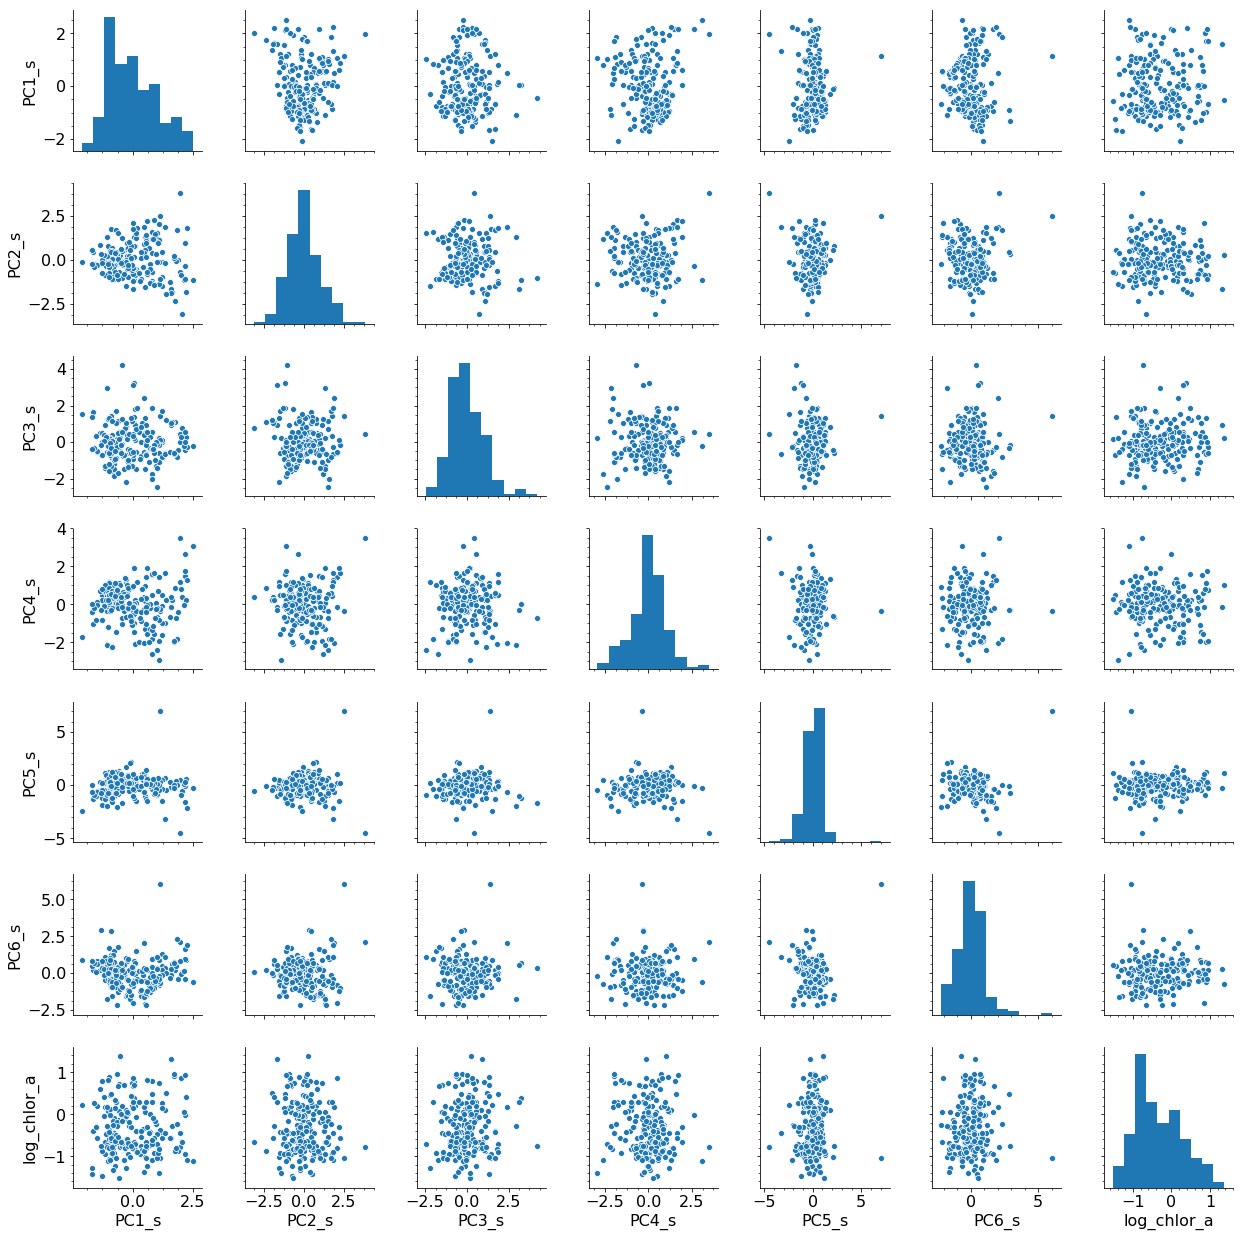

In [285]:
sb.pairplot(d)

In [273]:
X_ = X_train_pca_s.filter(regex='PC', axis=1).dropna()
y_ = y_train.loc[X_.index]
with pm.Model() as m_pca:
    α = pm.Normal('α', 0, 1) # prior on intercept
    β = pm.Normal('β', 0, 5, shape=X_.columns.size) # prior on slopes
    σ = pm.Exponential('σ', 1) # prior on likelihood variance
    μ = α + pm.math.dot(X_.values, β) # likelihood's mean deterministic model
    log_chl = pm.Normal('log_chl', mu=μ, sd=σ, observed=y_) # likelihood

In [190]:
m_pca_graph = pm.model_to_graphviz(m_pca)
m_pca_graph.format='png'
m_pca_graph.render(filename='m_pca_graph', directory='./resources/', view=False);

<center><img src='./resources/m_pca_graph.png?:2' width=700 /></center>

[Back to Contents](#TOP)

<a id='priors'></a>
#### b. Prior predictive simulation

In [253]:
def eval_priors(model, fpath, vars_=['α', 'β', 'log_chl'], ylim=(-5, 5)):
    # Sample parameters and simulate predictor from model priors
    # Sample parameters
    priors = pm.sample_prior_predictive(model=model, vars=vars_)
    β_prior = priors['β']
    α_prior = priors['α'].reshape(-1, 1)
    log_chl_prior = priors['log_chl']
    
    # Create dummy variable
    x_dummy = np.linspace(-3., 3., num=50).reshape(1, -1).repeat(6, axis=0)
    # Simulate log chl from model priors
    log_chl_lines = α_prior + np.dot(β_prior, x_dummy)

    f, ax = pl.subplots(ncols=2, figsize=(12, 4))
    for i in range(500):
        ax[0].plot(x_dummy[0], log_chl_lines[i], alpha=0.03, color='k')
    ax[0].set_ylim(ylim);
    ax[0]. set_xlabel(r'$PC1, standardized$')
    ax[0].set_ylabel(r'$log_{10}(chl)$')
    ax[1].hist(priors['log_chl'].flatten(), density=True, alpha=0.3, bins=100,
               orientation='horizontal', label='prior');
    ax[1].set_ylim(ylim)
    ax[1].set_xticklabels([])
    ax[1].yaxis.tick_right()
    ax[1].yaxis.set_label_position("right")
    ax[1].legend(loc='upper right')
    ax[1].set_ylabel(r'$log_{10}(chl)$')
    ax[1].set_xlabel(r'$Freq.$')
    ax2 = ax[1].twiny()
    ax2.hist(y_train.values, color='k', density=True, alpha=0.5, bins=20,
             orientation='horizontal', label='observed');
    ax2.set_xticklabels([])
    ax2.legend(loc='lower right')
    f.tight_layout()
    f.savefig(fpath, dpi=300)

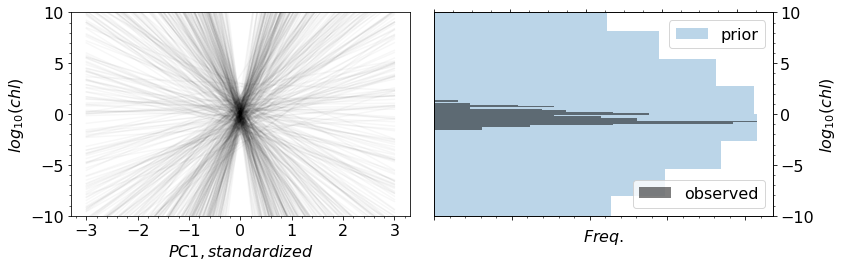

In [254]:
eval_priors(m_pca, fpath='./resources/priors_predictive_pca_wk_reg.png', ylim=(-10, 10))

<center><img src='./resources/priors_predictive_pca_wk_reg.png?:1'/></center>

$\Rightarrow$ Nonsensical log(chl) values $\rightarrow$ Priors too naive; need adjustment<br>
$\Rightarrow$ Informative priors $\rightarrow$ Incorportation of background knowledge into model

In [272]:
with pm.Model() as m_pca_wk_informative:
    α = pm.Normal('α', 0, 1) # prior on intercept
    β = pm.Normal('β', 0, 1, shape=X_.columns.size) # prior on slopes
    σ = pm.Exponential('σ', 1) # prior on likelihood variance
    μ = α + pm.math.dot(X_.values, β) # likelihood's mean deterministic model
    log_chl = pm.Normal('log_chl', mu=μ, sd=σ, observed=y_.values) # likelihood

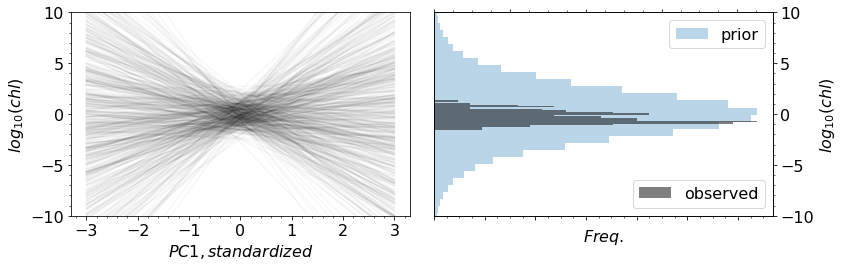

In [256]:
eval_priors(m_pca_wk_informative, fpath='./resources/priors_predictive_pca_wk_informative.png', ylim=(-10, 10))

<center><img src='./resources/priors_predictive_pca_wk_informative.png?:1'></center>

In [274]:
with pm.Model() as m_pca_informative:
    α = pm.Normal('α', 0, 1) # prior on intercept
    β = pm.Normal('β', 0, 0.1, shape=X_.columns.size) # prior on slopes
    σ = pm.Exponential('σ', 1) # prior on likelihood variance
    μ = α + pm.math.dot(X_.values, β) # likelihood's mean deterministic model
    log_chl = pm.Normal('log_chl', mu=μ, sd=σ, observed=y_.values) # likelihood

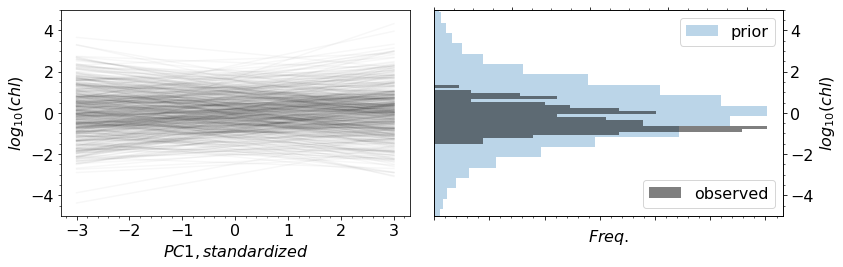

In [275]:
eval_priors(m_pca_informative, fpath='./resources/priors_predictive_pca_informative.png', ylim=(-5, 5))

<center><img src='./resources/priors_predictive_pca_informative.png?:1'/></center>

In [276]:
with m_pca_informative:
    trace_pca_informative = pm.sample(2000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [σ, β, α]
Sampling 2 chains: 100%|██████████| 6000/6000 [00:20<00:00, 285.78draws/s]


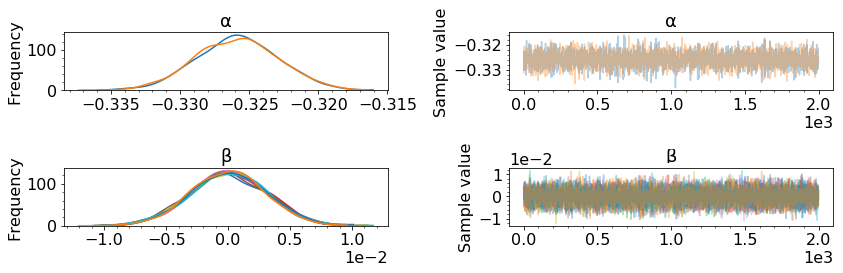

In [281]:
pm.traceplot(trace=trace_pca_informative, varnames=['α', 'β']);